# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [1]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
import wget
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=683a0e47d05605f5b3023f466d86721ef583219cd2399bfac5af0f06fe52d4d3
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Support functions and variables

In [0]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [0]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a)

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    
    
    ###########         end         ###########
    return matrix

In [0]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
          if rating == 0:
              # select the row for user
              # what's the shape of userVector
              userVector = train_matrix[user, :]

              # Extract the items the user already rated
              ratedItems = userVector[userVector.nonzero()]

              # If not empty, calculate average and set as rating for the current item
              if ratedItems.size == 0:
                  itemAvg = 0
              else:
                  itemAvg = ratedItems.mean()
              predictionMatrix[user, item] = itemAvg

          # report progress every 100 users
          if (user % 100 == 0 and item == 1):
              print ("calculated %d users" % (user,))


        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        
        # Initialize the predicted rating matrix with zeros
        
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [0]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
x = popularity_recsys.getModel()

In [0]:
np.all(x<=1)

True

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:37, 1024.69it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [0]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.61029412, 3.61029412,
        3.61029412],
       [0.        , 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [0]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:35, 1044.54it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


## Q2

### (a)

In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        similarity_matrix = pairwise_distances(matrix, metric='euclidean')
        similarity_matrix = 1/(1+similarity_matrix)
        
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
    
        similarity_matrix = abs(1- pairwise_distances(matrix, metric='correlation')) 
    
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
    
            useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
            
            
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            
            train_matrix = train_matrix.transpose()
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix)
            normalizer = np.matmul(ii_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
    
            itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            self.__model = predictionMatrix.transpose()
            
            
            
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [0]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [0]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [0]:
SimBasedRecSys.somethingelse(I)

array([[1. , 0.5, 0.5],
       [0.5, 1. , 0.5],
       [0.5, 0.5, 1. ]])

The cosine similarity is advantageious because even if the two similar documents are far apart by the Euclidean distance, chances are they may still be oriented closer together. The smaller the angle, higher the cosine similarity.

### (b)

Correlation was selected in this question. Correlation measures how related two vectors are, and the value is between -1 and 1, we take the absolute value of correlation to get the similarity matrix. It can be viewed as cosine similarity of two centered vecotrs, it is invariant to both scale and location changes of x and y. This is important because you often don't care that two vectors are similar in absolute terms, only that they vary in the same way.

## Q3

### (a)

In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:52, 885.15it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [0]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)
item_cosine_recsys.getModel()

array([[3.75429099, 3.66419957, 3.73222997, ..., 3.60248287, 3.79662696,
        3.90232044],
       [3.83658867, 3.80424519, 3.77473905, ..., 3.72798332, 3.9109779 ,
        3.79775927],
       [2.84492718, 2.89389328, 2.84327324, ..., 2.99504451, 3.16444153,
        2.9858119 ],
       ...,
       [4.11427954, 4.0558267 , 4.00963139, ..., 4.        , 3.87872799,
        4.14814803],
       [4.37096823, 4.39679254, 4.33543016, ..., 3.955358  , 4.41891089,
        4.57995134],
       [3.52030345, 3.46948821, 3.52393064, ..., 0.        , 3.6110641 ,
        3.59656861]])

In [0]:
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:35, 1042.43it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


### (b)

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [0]:
# How to use CrossValidation Class?

In [0]:
# 1. gather your algorithms in previous steps.
# algorithm_instances = [popularity_recsys, 
#                        average_user_rating_recsys, 
#                        user_cosine_recsys]

algorithm_instances = [user_cosine_recsys, item_cosine_recsys]

In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_patk = CrossValidation('RMSE')

In [0]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine


20000it [00:09, 2020.68it/s]
20000it [00:09, 2072.81it/s]
20000it [00:09, 2051.08it/s]
20000it [00:09, 2093.65it/s]
20000it [00:09, 2052.39it/s]


Processing algorithm item-cosine


20000it [00:09, 2080.97it/s]
20000it [00:09, 2060.31it/s]
20000it [00:09, 2094.12it/s]
20000it [00:09, 2097.48it/s]
20000it [00:09, 2080.56it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.0264490128856898,
   1.0214387664092763,
   1.0132940323507253,
   1.009400399702741,
   1.0161883960008826],
  1.017354121469863,
  1.0090130800118484,
  1.0256951629278774]}

The user-user similarity based method performed slightly better (with 1.017 RSME) than item-item similarity (with RSME of 1.020). This is probabaly resulted from more ratings per user than ratings per item, meaning that there are more zero entries.

## Q4

### (a)

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = np.sqrt(0.1)*np.random.randn(num_item, self.num_feat)  # item M x D 
        self.w_User = np.sqrt(0.1)*np.random.randn(num_user, self.num_feat)  # user N x D 
        
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
            
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID],self.w_Item[batch_ItemID]),axis=1) #size (batch_size, )
            
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx],self.w_Item[train_item_idx]),axis=1) # size(pairs_train, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx],self.w_Item[val_item_idx]),axis=1)  #size(pairs_val, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 20, "num_batches": 100,
                "batch_size": 1000, 'test_mode': False})

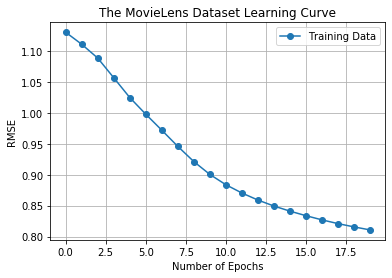

In [0]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

## Q5

### (a)

In [0]:
algorithm_instances = [pmf,
                       popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                       item_cosine_recsys
                       ]

In [0]:
eval_metrics_list = ['RMSE', 'P@K', 'R@K']

In [0]:
results_list = []

for metric in eval_metrics_list: 
  cv_patk = CrossValidation(metric)
  results_list.append(cv_patk.run(algorithm_instances, num_users, num_items,k=5))

Processing algorithm PMF


20000it [00:17, 1169.48it/s]
20000it [00:16, 1224.91it/s]
20000it [00:16, 1213.02it/s]
20000it [00:16, 1222.17it/s]
20000it [00:16, 1223.11it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2054.43it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2062.00it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2049.22it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2099.69it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2053.30it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2061.50it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2102.71it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2025.14it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2115.29it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1998.25it/s]


Processing algorithm user-cosine


20000it [00:09, 2015.66it/s]
20000it [00:09, 2083.62it/s]
20000it [00:09, 2061.60it/s]
20000it [00:09, 2058.14it/s]
20000it [00:09, 2071.78it/s]


Processing algorithm item-cosine


20000it [00:09, 2076.57it/s]
20000it [00:09, 2057.64it/s]
20000it [00:09, 2032.21it/s]
20000it [00:09, 2049.82it/s]
20000it [00:09, 2064.21it/s]


Processing algorithm PMF


20000it [00:16, 1200.08it/s]
20000it [00:16, 1203.22it/s]
20000it [00:16, 1202.40it/s]
20000it [00:16, 1216.66it/s]
20000it [00:16, 1195.56it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2010.33it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2092.33it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2052.82it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2079.23it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2120.95it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2028.59it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2070.14it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2082.03it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2047.64it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2027.21it/s]


Processing algorithm user-cosine


20000it [00:09, 2088.60it/s]
20000it [00:09, 2006.48it/s]
20000it [00:09, 2040.00it/s]
20000it [00:09, 2085.19it/s]
20000it [00:09, 2041.43it/s]


Processing algorithm item-cosine


20000it [00:09, 2067.04it/s]
20000it [00:09, 2003.40it/s]
20000it [00:09, 2043.68it/s]
20000it [00:10, 1993.20it/s]
20000it [00:09, 2017.71it/s]


Processing algorithm PMF


20000it [00:16, 1215.50it/s]
20000it [00:16, 1213.19it/s]
20000it [00:16, 1210.42it/s]
20000it [00:16, 1195.73it/s]
20000it [00:16, 1207.15it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2057.56it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2039.19it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2097.93it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2077.57it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2078.85it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2043.08it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2140.88it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2121.95it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2145.87it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2133.01it/s]


Processing algorithm user-cosine


20000it [00:09, 2127.63it/s]
20000it [00:09, 2068.55it/s]
20000it [00:09, 2144.67it/s]
20000it [00:09, 2108.71it/s]
20000it [00:09, 2115.80it/s]


Processing algorithm item-cosine


20000it [00:09, 2091.75it/s]
20000it [00:09, 2121.45it/s]
20000it [00:09, 2088.77it/s]
20000it [00:09, 2098.91it/s]
20000it [00:09, 2165.85it/s]


In [0]:
metricsList = list(results_list[0].keys())

result = []
for i, metric in enumerate(metricsList):
  res = []
  for j in range(len(eval_metrics_list)):
    res.append(round(results_list[j][metric][1],5))
  result.append([metric]+res)

In [0]:
header = [10*' ']+eval_metrics_list
metricsList = list(results_list[0].keys())
print('\t\t'.join(h for h in header))
 
for r in result:
  if r == result[0]:
    print(r[0] + '\t\t\t' +'\t\t'.join(str(e) for e in r[1:4]))
  else:
    print('\t\t'.join(str(e) for e in r))  

          		RMSE		P@K		R@K
PMF			0.96371		0.54808		0.47751
popularity		3.15909		0.55058		0.48408
useraverage		1.04372		0.47364		0.44132
user-cosine		1.01735		0.55584		0.48627
item-cosine		1.02008		0.53222		0.47497


### (b)

In the case of useraverage, p@k and r@k are not appropriate beacuse they have the same score for movies haven't seen. In the case of popularity, RMSE is not appropriate because popularity only ranks the top, and we don't care the lower rankings. All metrics can be used for collabrative filtering methods.

###(C)

PMF is the best algorithm for RMSE with lowest value of 0.96371 among all algorithms. The item feature vector can be viewed as the input and the user feature vector can be viewed as the weight. And this method is originally designed to learn both the weights and inputs by minimizing sqaured error. So the RMSE is the smallest.

User-cosine is the best algorithm for both P@k(0.55584) and R@k(0.48627). 

User-cosine is trying to rank the unseen movies based on the similarity to other users that share similar behaviours. 

###(d)

Good RMSE implies good performance on ranking metrics, but good performance on ranking metrics cannot imply good performance on RMSE. Because ranking focuses more on top-ranking items and doesn't care the low-ratings, while if the RMSE is very good, ranking certainly performed well for sure.

## Q6

### (a)

In [0]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [0]:
movies_Q6 = ['Kika (1993)', 'Fargo (1996)', 'Sudden Manhattan (1996)' ]

In [0]:
ii_matrix = dataPreprocessor(rating_df, num_users, num_items).transpose()
ii_similarity = 1-pairwise_distances(ii_matrix,metric='cosine')


In [0]:
movie_names = moviesDF.movieTitle.values
movie_sim_df = pd.DataFrame(data = ii_similarity, columns = movie_names, index = movie_names)
movie_sim_df

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),Seven (Se7en) (1995),"Usual Suspects, The (1995)",Mighty Aphrodite (1995),"Postino, Il (1994)",Mr. Holland's Opus (1995),French Twist (Gazon maudit) (1995),From Dusk Till Dawn (1996),"White Balloon, The (1995)",Antonia's Line (1995),Angels and Insects (1995),Muppet Treasure Island (1996),Braveheart (1995),Taxi Driver (1976),Rumble in the Bronx (1995),"Birdcage, The (1996)","Brothers McMullen, The (1995)",Bad Boys (1995),Apollo 13 (1995),Batman Forever (1995),Belle de jour (1967),Crimson Tide (1995),Crumb (1994),Desperado (1995),"Doom Generation, The (1995)",Free Willy 2: The Adventure Home (1995),Mad Love (1995),Nadja (1994),"Net, The (1995)",Strange Days (1995),"To Wong Foo, Thanks for Everything! Julie Newmar (1995)",...,Angel Baby (1995),Sudden Manhattan (1996),"Butcher Boy, The (1998)",Men With Guns (1997),Hana-bi (1997),"Niagara, Niagara (1997)","Big One, The (1997)","Butcher Boy, The (1998)","Spanish Prisoner, The (1997)",Temptress Moon (Feng Yue) (1996),Entertaining Angels: The Dorothy Day Story (1996),Chairman of the Board (1998),"Favor, The (1994)",Little City (1998),Target (1995),"Substance of Fire, The (1996)",Getting Away With Murder (1996),Small Faces (1995),"New Age, The (1994)",Rough Magic (1995),Nothing Personal (1995),8 Heads in a Duffel Bag (1997),"Brother's Kiss, A (1997)",Ripe (1996),"Next Step, The (1995)",Wedding Bell Blues (1996),MURDER and murder (1996),Tainted (1998),"Further Gesture, A (1996)",Kika (1993),Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
Toy Story (1995),1.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,0.468291,0.460392,0.417509,0.347678,0.574377,0.224120,0.273916,0.046232,0.191772,0.232930,0.339196,0.527169,0.338105,0.467598,0.567950,0.227295,0.208472,0.592877,0.361657,0.150959,0.439441,0.259257,0.288536,0.090654,0.136757,0.108560,0.069805,0.368420,0.278386,0.246123,...,0.065390,0.010550,0.023592,0.014155,0.023592,0.023592,0.023592,0.023592,0.023592,0.014226,0.0,0.058979,0.047183,0.032856,0.035387,0.048189,0.058979,0.058979,0.035387,0.0,0.0,0.067404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033363,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
GoldenEye (1995),0.402382,1.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,0.468506,0.459946,0.213972,0.125463,0.253162,0.098185,0.390438,0.113063,0.030692,0.091550,0.319308,0.483349,0.278182,0.434907,0.306639,0.206481,0.408737,0.483077,0.581119,0.089355,0.462797,0.160738,0.479187,0.072342,0.087347,0.215247,0.184592,0.562970,0.334570,0.256668,...,0.049324,0.035017,0.078299,0.046980,0.078299,0.078299,0.078299,0.078299,0.078299,0.000000,0.0,0.000000,0.078299,0.000000,0.104399,0.000000,0.000000,0.000000,0.104399,0.0,0.0,0.074571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055366,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
Four Rooms (1995),0.330245,0.273069,1.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,0.361165,0.319295,0.271402,0.190242,0.266335,0.167609,0.404239,0.126564,0.105377,0.187733,0.194546,0.293732,0.233814,0.381910,0.306447,0.214125,0.261303,0.269296,0.253074,0.126347,0.259129,0.185187,0.404930,0.179008,0.046315,0.073332,0.051270,0.240534,0.277311,0.176729,...,0.036615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009736,0.0,0.000000,0.096875,0.000000,0.000000,0.000000,0.064583,0.064583,0.096875,0.0,0.0,0.018452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
Get Shorty (1995),0.454938,0.502571,0.324866,1.000000,0.334239,0.090308,0.489283,0.490236,0.41

In [0]:
for movie in movies_Q6:
  print('Top 5 most similar movie names to {0} are:'.format(movie))
  print(movie_sim_df[movie].nlargest(6)[1:])
  print('\n')

Top 5 most similar movie names to Kika (1993) are:
You So Crazy (1994)         0.707107
Men With Guns (1997)        0.565685
Paris, France (1993)        0.462910
Lover's Knot (1996)         0.377964
Walking Dead, The (1995)    0.294884
Name: Kika (1993), dtype: float64


Top 5 most similar movie names to Fargo (1996) are:
Twelve Monkeys (1995)               0.690951
Star Wars (1977)                    0.686533
Godfather, The (1972)               0.646271
Pulp Fiction (1994)                 0.640382
Silence of the Lambs, The (1991)    0.635430
Name: Fargo (1996), dtype: float64


Top 5 most similar movie names to Sudden Manhattan (1996) are:
Nothing Personal (1995)      0.894427
Brother's Kiss, A (1997)     0.894427
Ripe (1996)                  0.894427
Next Step, The (1995)        0.894427
Wedding Bell Blues (1996)    0.894427
Name: Sudden Manhattan (1996), dtype: float64




### (b)

In [0]:
moviesDF[moviesDF['movieTitle'].isin(['Kika (1993)', 'You So Crazy (1994)', 'Men With Guns (1997)', 'Paris, France (1993)', "Lover's Knot (1996)", 'Walking Dead, The (1995)' ])]


,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
1350,1351,Lover's Knot (1996),12-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Lover's%20Kno...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1422,1423,"Walking Dead, The (1995)",01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Walking%20Dea...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1621,1622,"Paris, France (1993)",01-Jan-1993,NaN,"http://us.imdb.com/M/title-exact?Paris,%20Fran...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1645,1646,Men With Guns (1997),06-Mar-1998,NaN,http://us.imdb.com/Title?Men+with+Guns+(1997/I),0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1671,1672,Kika (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Kika%20(1993),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


For the movie 'Kika', the top recommendations performed not so good. 'Kika' is a drama, while 'You So Crazy' is a comedy, and 'Men with gun' is catogorized as action and drama, the third one 'Paris, France' is also a comedy. So that was propbably because the ratings are based on users who rated both, that didn't say both movies are same category and have similarity, people tend to rate the popular and good movies. So these similarities may work but not neccessarily can precisely identify the most 5 similar movies.  

## Q7

### (a)

In [0]:
rating_per_user = rating_df.groupby('userID').count().reset_index()

In [0]:
rating_per_user.drop('itemID',axis=1,inplace=True)
rating_per_user.drop('timestamp',axis=1,inplace=True)
rating_per_user

,userID,rating
0,1,272
1,2,62
2,3,54
3,4,24
4,5,175
...,...,...
938,939,49
939,940,107
940,941,22
941,942,79


Text(0, 0.5, 'Number of Users')

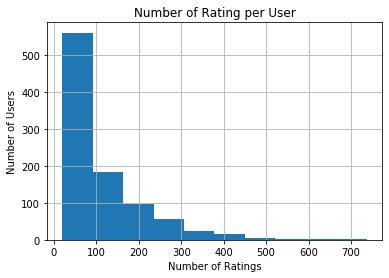

In [0]:
rating_per_user['rating'].hist()
plt.title('Number of Rating per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')

In [0]:
threshold = 100 ## randomly picked

In [0]:
rating_above = rating_df[rating_df['userID'].isin(rating_per_user[rating_per_user['rating']>=threshold].userID.tolist())]

In [0]:
rating_below = rating_df[rating_df['userID'].isin(rating_per_user[rating_per_user['rating']<threshold].userID.tolist())]

In [0]:
user_cosine_recsys_above = SimBasedRecSys('user','cosine')
user_cosine_recsys_above.predict_all(rating_above, num_users, num_items)
user_cosine_recsys_above.getModel()

array([[3.91673994, 3.19074322, 3.01097464, ..., 2.        , 3.        ,
        3.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.93817091, 3.24649499, 3.05914204, ..., 0.        , 3.        ,
        3.        ]])

In [0]:
uu_above = user_cosine_recsys_above.evaluate_test(rating_above, copy = True)

74522it [01:02, 1187.04it/s]


In [0]:
uu_above.head()

,userID,itemID,rating,timestamp,user-cosine
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.438432
5,298,474,4,884182806,4.223868
8,305,451,3,886324817,3.301233
9,6,86,3,883603013,3.839340


In [0]:
item_cosine_recsys_above = SimBasedRecSys('item','cosine')
item_cosine_recsys_above.predict_all(rating_above, num_users, num_items)
item_cosine_recsys_above.getModel()

array([[3.73660658, 3.67869298, 3.74436382, ..., 3.64660427, 3.80569433,
        3.91653056],
       [3.90977429, 3.20967716, 2.97333294, ..., 1.99998   , 2.99997   ,
        2.99997   ],
       [3.90977429, 3.20967716, 2.97333294, ..., 1.99998   , 2.99997   ,
        2.99997   ],
       ...,
       [3.90977429, 3.20967716, 2.97333294, ..., 1.99998   , 2.99997   ,
        2.99997   ],
       [3.90977429, 3.20967716, 2.97333294, ..., 1.99998   , 2.99997   ,
        2.99997   ],
       [3.51018848, 3.49076308, 3.53965393, ..., 0.        , 3.63260019,
        3.60797187]])

In [0]:
ii_above = item_cosine_recsys_above.evaluate_test(rating_above, copy = True)

74522it [01:03, 1175.92it/s]


In [0]:
ii_above.head()

,userID,itemID,rating,timestamp,item-cosine
2,22,377,1,878887116,2.981518
3,244,51,2,880606923,3.639406
5,298,474,4,884182806,4.138747
8,305,451,3,886324817,3.361837
9,6,86,3,883603013,3.739005


In [0]:
user_cosine_recsys_below = SimBasedRecSys('user','cosine')
user_cosine_recsys_below.predict_all(rating_below, num_users, num_items)
user_cosine_recsys_below.getModel()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.85666132, 3.16276759, 3.09205368, ..., 3.70967682, 3.70967682,
        3.70967682],
       [3.88086201, 3.2051875 , 3.34206186, ..., 2.79629578, 2.79629578,
        2.79629578],
       ...,
       [3.89038921, 3.22010521, 3.41185056, ..., 4.04545271, 4.04545271,
        4.04545271],
       [3.85682727, 3.15965855, 3.23897949, ..., 4.26582224, 4.26582224,
        4.26582224],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [0]:
uu_below = user_cosine_recsys_below.evaluate_test(rating_below, copy = True)

25478it [00:13, 1931.86it/s]


In [0]:
uu_below.head()

,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.132461
1,186,302,3,891717742,4.107096
4,166,346,1,886397596,3.294595
6,115,265,2,881171488,3.643232
7,253,465,5,891628467,4.368684


In [0]:
item_cosine_recsys_below = SimBasedRecSys('item','cosine')
item_cosine_recsys_below.predict_all(rating_below, num_users, num_items)
item_cosine_recsys_below.getModel()

array([[3.83333313, 3.14285265, 3.33333111, ..., 0.        , 0.        ,
        0.        ],
       [3.87593919, 4.11381213, 3.71991111, ..., 0.        , 0.        ,
        0.        ],
       [2.84801746, 3.07924407, 2.67806901, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [4.15190156, 4.19491651, 3.95025135, ..., 0.        , 0.        ,
        0.        ],
       [4.32013731, 4.45291796, 4.15738574, ..., 0.        , 0.        ,
        0.        ],
       [3.83333313, 3.14285265, 3.33333111, ..., 0.        , 0.        ,
        0.        ]])

In [0]:
ii_below = item_cosine_recsys_below.evaluate_test(rating_below, copy = True)

25478it [00:13, 1938.43it/s]


In [0]:
ii_below.head()

,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.590650
1,186,302,3,891717742,3.143764
4,166,346,1,886397596,3.255303
6,115,265,2,881171488,3.952813
7,253,465,5,891628467,4.199384


In [0]:
df_list = [uu_above, uu_below, ii_above, ii_below]
user_item_threshold = ['user-user above threshold', 'user-user below threshold', 'item-item above threshold', 'item-item below threshold']


In [0]:
for i,df in enumerate(df_list):
  predict = df.iloc[:,-1]
  rating = df.loc[:]['rating']
  rsme = sqrt(mean_squared_error(predict,rating))
  print('RSME of {0} is: {1} '.format(user_item_threshold[i], rsme))

RSME of user-user above threshold is: 0.9481767606298663 
RSME of user-user below threshold is: 0.8901312664100373 
RSME of item-item above threshold is: 0.9946094755385316 
RSME of item-item below threshold is: 0.8942223431150697 


The subset of below the threshold performed similar with very close RSMEs, it probably because the majority of entries are 0. And for the subset of above the threshold, user-user collabrative filtering performed better, might because there are more users above the threshold.

# Validation

In [0]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [0]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [0]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [0]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [0]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUserAverRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [0]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [0]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [0]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [0]:
validateCustomizedSim()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


### User-User Similarity Based Recommendation System

In [0]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUUSimBasedRecSys()

### Item-Item Similarity Based Recommendation System

In [0]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateIISimBasedRecSys()

### Probabilistic Matrix Factorization Recommendation System

In [0]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [0]:
validatePMFRecSys(validation_df=validation_df)